# Smoothed Source models for Nath & Thingbaijam (2012)

Read the source description input files from the online supplementary
material and write them to XML. Must be run after areal soruce models are generated, because zone assignments for points are done on the basis of the areal source model.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import sys
import ast

from io import BytesIO
from IPython.display import display
from IPython import get_ipython
from time import sleep

import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
from shapely.wkt import loads, dumps

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from obspy.imaging.beachball import beachball, aux_plane

from openquake.hazardlib import tom, geo
import openquake.hmtk.sources as src
from openquake.hmtk.plotting.mapping import HMTKBaseMap
from openquake.hmtk.parsers.source_model.nrml04_parser import \
    nrmlSourceModelParser

In [3]:
sys.path.append('../utilities')
import source_model_tools as smt  # noqa
import toolbox as tb  # noqa

In [4]:
# define some lists needed at different stages
min_mags = [4.5, 5.5]

layer_ids = [1, 2, 3, 4]
layer_depths_km = [0., 25., 70., 180., 300.]

layers_df = pd.DataFrame(list(zip(layer_ids,
                                  layer_depths_km[:-1],
                                  layer_depths_km[1:])),
                         columns=['id', 'zmin', 'zmax'])
layers_df['id'] = layers_df['id'].astype(int)

layers_df

,id,zmin,zmax
0,1,0.0,25.0
1,2,25.0,70.0
2,3,70.0,180.0
3,4,180.0,300.0


In [5]:
use_recomputed = False

# define the input file names from the original paper
model_path = '../Data/nath2012probabilistic'
if use_recomputed:
    smoothed_model_path = '../Smoothed/Recomputed'
else:
    smoothed_model_path = model_path
polygon_file_template = os.path.join(model_path, 'polygonlay%d.txt')
seismicity_file_template = os.path.join(model_path, 'seismicitylay%d.txt')
polygon_files = [polygon_file_template % i for i in layer_ids]
seismicity_files = [seismicity_file_template % i for i in layer_ids]

smoothed_data_template = os.path.join(smoothed_model_path,
                                      'lay%dsmooth%.1f.txt')
smoothed_data_files = [[smoothed_data_template % (i, m)
                        for i in layer_ids] for m in min_mags]

# implement some column-name replacements
variable_mapping = {'avalue': 'a', 'bvalue': 'b', 'stdbvalue': 'stdb'}

# an input file supplies some auxiliary data
aux_file = 'auxiliary data.csv'

# define prefixes for the output file names and models
areal_source_model_file = 'areal_source_model'
smoothed_source_data_file = 'smoothed_source_model'

In [6]:
# read (augmented) areal zone descriptions
areal_df = pd.read_table(areal_source_model_file + '.tsv')
# areal_df.set_index('id', verify_integrity=True, inplace=True)
areal_df['geometry'] = areal_df['geometry'].apply(loads)
areal_df = gpd.GeoDataFrame(areal_df, crs='WGS84')
areal_df.head()

,id,zoneid,layerid,tectonic subregion,mmin,a,aspect ratio,b,centroid latitude,centroid longitude,...,rake,rake2,region,stdb,stdmmax,strike,strike2,tectonic zone,zmax,zmin
0,z1,1,1,subduction interface,4.5,5.20,2,1.05,38.794988,70.440638,...,30.0,160.6,Pamirs,0.07,0.4,202.0,102.4,Subduction interface,25,0
1,z1m,1m,1,subduction interface megathrust,7.5,5.20,2,1.05,38.794988,70.440638,...,30.0,160.6,Pamirs,0.07,0.4,202.0,102.4,Subduction interface,25,0
2,z2,2,1,subduction interface,4.5,4.64,2,0.93,39.234824,74.792116,...,142.0,64.7,Pamirs,0.09,0.4,306.0,69.8,Subduction interface,25,0
3,z2m,2m,1,subduction interface megathrust,7.5,4.64,2,0.93,39.234824,74.792116,...,142.0,64.7,Pamirs,0.09,0.4,306.0,69.8,Subduction interface,25,0
4,z3,3,1,active shallow crust strike-slip reverse,4.5,3.75,2,0.77,39.433139,77.662187,...,33.0,178.8,Qaidam,0.05,0.4,59.0,328.4,Active shallow crust,25,0


In [7]:
# read completeness table in anticipation of computing activity rates from catalogues
completeness_df = pd.read_csv('../Data/thingbaijam2011seismogenic/Table1.csv',
                              header=[0, 1], index_col=[0, 1])
# completeness_df.reset_index(inplace=True)
completeness_df.columns = [' '.join(col).strip()
                           for col in completeness_df.columns.values]
completeness_df.reset_index(inplace=True)
display(completeness_df)

,zmin,zmax,4 start,4 end,4.5 start,4.5 end,5.5 start,5.5 end
0,0,25,1994,2008,1964,2008,1903,2008
1,25,70,1990,2008,1964,2008,1902,2008
2,70,180,1996,2008,1964,2008,1914,2008
3,180,300,1970,2008,1984,2008,1912,2008


In [8]:
# read smoothed seismicity data
smoothed_df_list = []
for i, mag in enumerate(min_mags):
    layer_smoothed_df_list = []
    for j, layer in pd.merge(completeness_df, layers_df).iterrows():
        layer_smoothed_df = pd.read_csv(smoothed_data_files[i][j])
        nu_mag = 'nu%s' % str(mag).replace('.', '_')

        rename_cols = {nu_mag: 'nu', 'lat': 'latitude', 'lon': 'longitude'}
        layer_smoothed_df.rename(columns=rename_cols, inplace=True)

        layer_smoothed_df['layerid'] = layer['id']
        layer_smoothed_df['mmin model'] = mag
        layer_smoothed_df['mmin'] = mag
        layer_smoothed_df['duration'] = (layer[str(mag) + ' end'] -
                                         layer[str(mag) + ' start'] + 1)
        if use_recomputed:
            layer_smoothed_df['lambda'] = layer_smoothed_df['nu']
            layer_smoothed_df['nu'] = (layer_smoothed_df['lambda'] *
                                       layer_smoothed_df['duration'])
        else:
            layer_smoothed_df['lambda'] = (layer_smoothed_df['nu'] /
                                           layer_smoothed_df['duration'])

        layer_smoothed_df_list.append(layer_smoothed_df)

    layer_smoothed_df = pd.concat(layer_smoothed_df_list)
    smoothed_df_list.append(layer_smoothed_df)

smoothed_df = pd.concat(smoothed_df_list)
smoothed_df = smt.sort_and_reindex(smoothed_df)
smoothed_df['geometry'] = [Point(longitude, latitude) 
                           for longitude, latitude in zip(smoothed_df['longitude'], 
                                                          smoothed_df['latitude'])]
smoothed_df = gpd.GeoDataFrame(smoothed_df, crs='WGS84')

display(pd.concat((smoothed_df.head(), smoothed_df.tail())))

,longitude,latitude,layerid,mmin,duration,lambda,mmin model,nu,geometry
0,60.0,23.1,2,4.5,45,0.000002,4.5,0.0001,POINT (60 23.1)
1,60.0,23.2,2,4.5,45,0.000002,4.5,0.0001,POINT (60 23.2)
2,60.0,23.3,2,4.5,45,0.000002,4.5,0.0001,POINT (60 23.3)
3,60.0,23.4,2,4.5,45,0.000002,4.5,0.0001,POINT (60 23.4)
4,60.0,23.5,2,4.5,45,0.000002,4.5,0.0001,POINT (60 23.5)
393416,100.6,3.8,3,5.5,95,0.000044,5.5,0.0042,POINT (100.6 3.8)
393417,100.7,3.6,1,4.5,45,0.000018,4.5,0.0008,POINT (100.7 3.6)
393418,100.7,3.6,2,4.5,45,0.000289,4.5,0.0130,POINT (100.7 3.6)
393419,100.7,3.6,3,4.5,45,0.000627,4.5,0.0282,POINT (100.7 3.6)
393420,100.7,3.6,3,5.5,95,0.000026,5.5,0.0025,POINT (100.7 3.6)


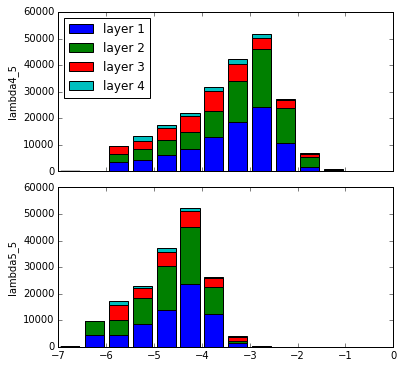

In [9]:
prop = 'lambda'
fig, axes = plt.subplots(nrows=len(min_mags), ncols=1,
                         figsize=(6, 3*len(min_mags)), sharex=True)
fig.subplots_adjust(hspace=0.1)
for min_mag, ax in zip(min_mags, axes):
    groups = smoothed_df[
        smoothed_df['mmin model'] == min_mag].groupby('layerid')
    data = [np.log10(group[prop]).values for _, group in groups]
    labels = ['layer %d' % id for id, _ in groups]
    ax.hist(data, label=labels, stacked=True, bins=np.arange(-7, 0, 0.5))
    ax.set_ylabel(('%s%g' % (prop, min_mag)).replace('.', '_'))
axes[0].legend(loc='upper left')
fig.savefig(os.path.join(smoothed_model_path,
                         'SmoothedModelActivityRates.png'),
            dpi=300, transparent=True, bbox_inches='tight', pad_inches=0.1)
plt.close(fig)  # uncomment to view in notebook

In [10]:
# compute all distances - for many points we need the nearest zone
areal_df['polygon'] = [
    smt.MyPolygon([geo.point.Point(lat, lon)
                   for lat, lon in zip(*area_series.geometry.exterior.coords.xy)])
    for _, area_series in areal_df.iterrows()]
distances = np.full((len(smoothed_df), len(areal_df)), np.inf)
for i, area_series in areal_df[areal_df['tectonic subregion'] != 'no seismicity'].iterrows():
    at_depth = (smoothed_df['layerid'] == area_series['layerid']).values
    mesh = geo.mesh.Mesh(
        smoothed_df.loc[at_depth, 'longitude'].values,
        smoothed_df.loc[at_depth, 'latitude'].values)
    distances[at_depth, i] = area_series['polygon'].distances(mesh)

In [11]:
distances.min(axis=1).shape

(393421,)

In [12]:
zone_id = '118'
this_model = smoothed_df['mmin model'] == 4.5
this_zone = areal_df['zoneid'] == zone_id
n_points_in_area = (distances == 0).sum(axis=0)
drop_cols = ['tectonic subregion','region', 'tectonic zone',
             'aspect ratio']
fmd_cols = ['zoneid','layerid','a','b','stdb','mmax','stdmmax','mmin','geometry']

print(n_points_in_area[areal_df[this_zone].index[0]])
display(areal_df[this_zone][fmd_cols])
print(areal_df[this_zone]['b']*areal_df[this_zone]['mmin'])
in_zone = (distances[:, areal_df[this_zone].index] == 0)

426


,zoneid,layerid,a,b,stdb,mmax,stdmmax,mmin,geometry
60,118,2,4.67,1.05,0.12,7.2,0.4,4.5,"POLYGON ((93.47 26.91, 94.06999999999999 26.1,..."


60    4.725
dtype: float64


The truncated Gutenberg-Richter magnitude-frequency distribution in OpenQuake implements
$$\lambda(m \geq M) = 10^{a - b m} = e^{\alpha - \beta m}$$
where, since $\lambda$ is an annual rate, $10^a$ is too. If we ignore events below some threshold $m_{min}$ then the annual rate becomes
$$\lambda(m \geq m_{min}) = e^{\alpha - \beta m_{min}} e^{-\beta (m - m_{min})} = \nu e^{-\beta (m - m_{min})} $$
Thus to compute the $a$ value required by OpenQuake from the activity rate $\lambda$ for a given magnitude threshold, we must also take into account the $b$ value for the zone:
$$a = \log_{10}(\lambda) + b m_{min}$$
If instead what is provided is event counts $\nu$ over some catalog duration $T$, then one simply computes $\lambda = \nu/T$

In [13]:
# for each point in the smoothed model, choose the closest areal zone
# and copy some useful columns over
columns_to_copy = ['zoneid', 'zmax', 'zmin', 'tectonic subregion', 
                   'a', 'b', 'stdb', 'mmax', 'stdmmax', 
                    'rake', 'dip', 'strike', 'aspect ratio', 'msr']
index_min = distances.argmin(axis=1)
for i, area_series in areal_df[
        areal_df['tectonic subregion'] != 'no seismicity'].iterrows():
    picked = i == index_min
    for column in columns_to_copy:
        smoothed_df.loc[picked, column] = area_series[column]
    # grab mmax and bvalue from zone above if mmax zero for this zone
    if area_series['mmax'] == 0:
        alternate_zone = str(int(np.floor(float(area_series['zoneid'])/10)))
        print('For', area_series['zoneid'], 'using MFD from', alternate_zone)
        index_alt = np.where(areal_df['zoneid'] == alternate_zone)[0]
        if len(index_alt) > 0:
            smoothed_df.loc[picked, 'mmax'] = areal_df.loc[index_alt[0],
                                                           'mmax']
            smoothed_df.loc[picked, 'b'] = areal_df.loc[index_alt[0], 'b']

pd.concat((smoothed_df.head(), smoothed_df.tail()))

,longitude,latitude,layerid,mmin,duration,lambda,mmin model,nu,geometry,zoneid,...,a,b,stdb,mmax,stdmmax,rake,dip,strike,aspect ratio,msr
0,60.0,23.1,2,4.5,45,0.000002,4.5,0.0001,POINT (60 23.1),95,...,4.35,0.94,0.13,7.6,0.4,167.0,79.0,23.0,2.0,StrasserInterface
1,60.0,23.2,2,4.5,45,0.000002,4.5,0.0001,POINT (60 23.2),95,...,4.35,0.94,0.13,7.6,0.4,167.0,79.0,23.0,2.0,StrasserInterface
2,60.0,23.3,2,4.5,45,0.000002,4.5,0.0001,POINT (60 23.3),95,...,4.35,0.94,0.13,7.6,0.4,167.0,79.0,23.0,2.0,StrasserInterface
3,60.0,23.4,2,4.5,45,0.000002,4.5,0.0001,POINT (60 23.4),95,...,4.35,0.94,0.13,7.6,0.4,167.0,79.0,23.0,2.0,StrasserInterface
4,60.0,23.5,2,4.5,45,0.000002,4.5,0.0001,POINT (60 23.5),95,...,4.35,0.94,0.13,7.6,0.4,167.0,79.0,23.0,2.0,StrasserInterface
393416,100.6,3.8,3,5.5,95,0.000044,5.5,0.0042,POINT (100.6 3.8),167,...,5.41,1.07,0.09,8.0,0.3,46.0,49.0,206.0,2.0,StrasserIntraslab
393417,100.7,3.6,1,4.5,45,0.000018,4.5,0.0008,POINT (100.7 3.6),58,...,4.95,0.95,0.06,8.4,0.4,180.0,75.0,151.0,2.0,WC1994
393418,100.7,3.6,2,4.5,45,0.000289,4.5,0.0130,POINT (100.7 3.6),138,...,5.62,1.10,0.09,7.5,0.3,18.0,80.0,64.0,2.0,StrasserInterface
393419,100.7,3.6,3,4.5,45,0.000627,4.5,0.0282,POINT (100.7 3.6),167,...,5.41,1.07,0.09,8.0,0.3,46.0,49.0,206.0,2.0,StrasserIntraslab
393420,100.7,3.6,3,5.5,95,0.000026,5.5,0.0025,POINT (100.7 3.6),167,...,5.41,1.07,0.09,8.0,0.3,46.0,49.0,206.0,2.0,StrasserIntraslab


In [14]:
# computing the a-value for each point is now easy
smoothed_df['nearest'] = distances.min(axis=1)
smoothed_df['a'] = (np.log10(smoothed_df['lambda']) +
                    smoothed_df['b']*smoothed_df['mmin model'])

# for each area in the areal model: count the number of points and
# sum the activity rates in the smoothed model. from the latter estimate
# an equivalent a-value
for mag in min_mags:
    this_model = smoothed_df['mmin model'] == mag
    sum_lambda = np.array([
        smoothed_df.loc[(distance == 0) & this_model.values, 'lambda'].sum()
        for distance in distances.T])
    areal_df['smoothed N ' + str(mag)] = (
        distances[this_model.values, :] == 0).sum(axis=0)
    areal_df['smoothed lambda ' + str(mag)] = sum_lambda.round(4)
    areal_df['smoothed a ' + str(mag)] = (
        np.log10(sum_lambda) + areal_df['b']*mag).round(2)
    areal_df['equiv a ' + str(mag)] = (
        areal_df['a']/areal_df['smoothed N ' + str(mag)])
    areal_df['areal lambda ' + str(mag)] = (
        10**(areal_df['a'] - areal_df['b']*mag)).round(4)

In [15]:
display_drop = ['zmax', 'zmin', 'aspect ratio', 'msr',
                'rake', 'dip', 'strike', 'stdb', 'stdmmax']
no_mmax_df = smoothed_df[smoothed_df['mmax'] == 0]
if len(no_mmax_df) > 0:
    print("Leftover points with no assigned mmax")
    display(no_mmax_df.drop(display_drop, axis=1).head())
no_b_df = smoothed_df[smoothed_df['b'] == 0]
if len(no_b_df) > 0:
    print("Leftover points with no assigned b")
    display(no_b_df.drop(display_drop, axis=1).head())
no_zoneid_df = smoothed_df[smoothed_df['zoneid'].isnull()]
if len(no_zoneid_df) > 0:
    print("Leftover points with no assigned zone id")
    display(no_zoneid_df.drop(display_drop, axis=1).head())
if not len(no_mmax_df) and not len(no_b_df) and not len(no_zoneid_df):
    print("SUCCESS: No points with unassigned MFD or zone")

SUCCESS: No points with unassigned MFD or zone


In [16]:
pd.concat((smoothed_df.head(), smoothed_df.tail())).drop(display_drop, axis=1)

,longitude,latitude,layerid,mmin,duration,lambda,mmin model,nu,geometry,zoneid,tectonic subregion,a,b,mmax,nearest
0,60.0,23.1,2,4.5,45,0.000002,4.5,0.0001,POINT (60 23.1),95,subduction interface,-1.423213,0.94,7.6,46.648981
1,60.0,23.2,2,4.5,45,0.000002,4.5,0.0001,POINT (60 23.2),95,subduction interface,-1.423213,0.94,7.6,36.231915
2,60.0,23.3,2,4.5,45,0.000002,4.5,0.0001,POINT (60 23.3),95,subduction interface,-1.423213,0.94,7.6,26.384012
3,60.0,23.4,2,4.5,45,0.000002,4.5,0.0001,POINT (60 23.4),95,subduction interface,-1.423213,0.94,7.6,18.063148
4,60.0,23.5,2,4.5,45,0.000002,4.5,0.0001,POINT (60 23.5),95,subduction interface,-1.423213,0.94,7.6,14.257911
393416,100.6,3.8,3,5.5,95,0.000044,5.5,0.0042,POINT (100.6 3.8),167,subduction intraslab,1.530526,1.07,8.0,173.377186
393417,100.7,3.6,1,4.5,45,0.000018,4.5,0.0008,POINT (100.7 3.6),58,active shallow crust strike-slip reverse,-0.475123,0.95,8.4,0.000000
393418,100.7,3.6,2,4.5,45,0.000289,4.5,0.0130,POINT (100.7 3.6),138,subduction interface,1.410731,1.10,7.5,114.063038
393419,100.7,3.6,3,4.5,45,0.000627,4.5,0.0282,POINT (100.7 3.6),167,subduction intraslab,1.612037,1.07,8.0,181.051288
393420,100.7,3.6,3,5.5,95,0.000026,5.5,0.0025,POINT (100.7 3.6),167,subduction intraslab,1.305216,1.07,8.0,181.051288


In [17]:
this_lon_lat = ((smoothed_df['longitude'] == 98.0) &
                (smoothed_df['latitude'] == 3.8))
display(smoothed_df[this_lon_lat].drop(display_drop, axis=1))

,longitude,latitude,layerid,mmin,duration,lambda,mmin model,nu,geometry,zoneid,tectonic subregion,a,b,mmax,nearest
384447,98.0,3.8,1,4.5,45,0.002449,4.5,0.1102,POINT (98 3.8),58,active shallow crust strike-slip reverse,1.663969,0.95,8.4,0.0
384448,98.0,3.8,1,5.5,106,0.000161,5.5,0.0171,POINT (98 3.8),58,active shallow crust strike-slip reverse,1.432690,0.95,8.4,0.0
384449,98.0,3.8,2,4.5,45,0.003558,4.5,0.1601,POINT (98 3.8),138,subduction interface,2.501179,1.10,7.5,0.0
384450,98.0,3.8,2,5.5,107,0.000264,5.5,0.0282,POINT (98 3.8),138,subduction interface,2.470865,1.10,7.5,0.0
384451,98.0,3.8,3,4.5,45,0.005931,4.5,0.2669,POINT (98 3.8),167,subduction intraslab,2.588136,1.07,8.0,0.0
384452,98.0,3.8,3,5.5,95,0.000143,5.5,0.0136,POINT (98 3.8),167,subduction intraslab,2.040815,1.07,8.0,0.0
384453,98.0,3.8,4,4.5,25,0.001808,4.5,0.0452,POINT (98 3.8),172,subduction intraslab,1.127198,0.86,8.0,0.0
384454,98.0,3.8,4,5.5,97,0.000022,5.5,0.0021,POINT (98 3.8),172,subduction intraslab,0.065448,0.86,8.0,0.0


In [18]:
areal_display_drop = display_drop + ['polygon', 'tectonic zone', 'concerns', 'layerid']
pd.concat((areal_df.head(), areal_df.tail())).drop(areal_display_drop, axis=1)

,id,zoneid,tectonic subregion,mmin,a,b,centroid latitude,centroid longitude,dip2,geometry,...,smoothed N 4.5,smoothed lambda 4.5,smoothed a 4.5,equiv a 4.5,areal lambda 4.5,smoothed N 5.5,smoothed lambda 5.5,smoothed a 5.5,equiv a 5.5,areal lambda 5.5
0,z1,1,subduction interface,4.5,5.20,1.05,38.794988,70.440638,61.4,"POLYGON ((67.81 37.55, 68.3 38.82, 72.95 39.99...",...,545,7.0560,5.57,0.009541,2.9854,545,0.1066,4.80,0.009541,0.2661
1,z1m,1m,subduction interface megathrust,7.5,5.20,1.05,38.794988,70.440638,61.4,"POLYGON ((67.81 37.55, 68.3 38.82, 72.95 39.99...",...,545,7.0560,5.57,0.009541,2.9854,545,0.1066,4.80,0.009541,0.2661
2,z2,2,subduction interface,4.5,4.64,0.93,39.234824,74.792116,71.5,"POLYGON ((72.95 39.99, 76.53 39.99, 76.0999999...",...,487,5.5615,4.93,0.009528,2.8510,487,0.1391,4.26,0.009528,0.3350
3,z2m,2m,subduction interface megathrust,7.5,4.64,0.93,39.234824,74.792116,71.5,"POLYGON ((72.95 39.99, 76.53 39.99, 76.0999999...",...,487,5.5615,4.93,0.009528,2.8510,487,0.1391,4.26,0.009528,0.3350
4,z3,3,active shallow crust strike-slip reverse,4.5,3.75,0.77,39.433139,77.662187,57.0,"POLYGON ((76.09999999999999 38.89, 76.53 39.99...",...,315,3.1065,3.96,0.011905,1.9275,315,0.1115,3.28,0.011905,0.3273
123,z9031,9031,no seismicity,4.5,0.00,0.00,22.759109,63.890879,90.0,"POLYGON ((66.31 24.82, 68.09 22.65, 61.55 20.3...",...,0,NaN,NaN,NaN,1.0000,0,NaN,NaN,NaN,1.0000
124,z9081,9081,no seismicity,4.5,0.00,0.00,29.074076,95.649902,90.0,"POLYGON ((92.03 32.12, 98.67 28.35, 98.41 26.3...",...,0,NaN,NaN,NaN,1.0000,0,NaN,NaN,NaN,1.0000
125,z9131,9131,no seismicity,4.5,0.00,0.00,22.041780,91.829942,90.0,"POLYGON ((93.76000000000001 18.44, 90.65000000...",...,0,NaN,NaN,NaN,1.0000,0,NaN,NaN,NaN,1.0000
126,z9151,9151,no seismicity,4.5,0.00,0.00,16.456705,92.439141,90.0,"POLYGON ((92.45 13.67, 90.72 14.32, 91.75 16.4...",...,0,NaN,NaN,NaN,1.0000,0,NaN,NaN,NaN,1.0000
127,z9171,9171,no seismicity,4.5,0.00,0.00,9.733105,88.684630,90.0,"POLYGON ((90.65000000000001 20.8, 92.11 19.69,...",...,0,NaN,NaN,NaN,1.0000,0,NaN,NaN,NaN,1.0000


In [19]:
activity_df = areal_df[[
        'zoneid', 'layerid', 'areal lambda 4.5', 'areal lambda 5.5',
        'smoothed lambda 4.5', 'smoothed lambda 5.5', 'smoothed N 4.5',
        'smoothed N 5.5']]
activity_df = activity_df.rename(
    columns={'areal lambda 4.5': 'areal 4.5',
             'smoothed lambda 4.5': 'smoothed 4.5',
             'areal lambda 5.5': 'areal 5.5',
             'smoothed lambda 5.5': 'smoothed 5.5',
             'smoothed N 4.5': 'N 4.5',
             'smoothed N 5.5': 'N 5.5'})

for layer_id in layer_ids:
    series = pd.Series(activity_df[
        activity_df['layerid'] == layer_id].sum(axis=0))
    series['layerid'] = layer_id
    series['zoneid'] = 'All'
    activity_df = activity_df.append(series, ignore_index=True)

series = pd.Series(activity_df[activity_df['zoneid'] == 'All'].sum(axis=0))
series['layerid'] = 'All'
series['zoneid'] = 'All'
activity_df = activity_df.append(series, ignore_index=True)
activity_df['ratio 4.5'] = (activity_df['smoothed 4.5'] /
                            activity_df['areal 4.5']).round(2)
activity_df['ratio 5.5'] = (activity_df['smoothed 5.5'] /
                            activity_df['areal 5.5']).round(2)

picked_zones = [(activity_df['zoneid'] == zone).argmax()
                for zone in ['21', '22']]
display(pd.concat((activity_df.loc[picked_zones, :],
                   activity_df[activity_df['zoneid'] == 'All'])))
activity_df.to_csv(os.path.join(
    smoothed_model_path, 'activity_rates_by_zone_areal_vs_smoothed.csv'), float_format='%.12g')

/home/nick/anaconda3/envs/oq/lib/python3.5/site-packages/ipykernel_launcher.py:30: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.


,zoneid,layerid,areal 4.5,areal 5.5,smoothed 4.5,smoothed 5.5,N 4.5,N 5.5,ratio 4.5,ratio 5.5
21,21,1,1.1092,0.1567,4.9396,0.1270,1240.0,1240.0,4.45,0.81
23,22,1,1.1350,0.2113,1.9719,0.0606,907.0,907.0,1.74,0.29
128,All,1,98.8086,10.8745,172.5360,5.4390,93993.0,76151.0,1.75,0.50
129,All,2,101.3192,13.5314,261.0435,5.4793,80776.0,70513.0,2.58,0.40
130,All,3,35.7063,2.9145,88.4988,1.6926,19337.0,14108.0,2.48,0.58
131,All,4,11.4753,1.5774,42.6027,1.2253,4768.0,2936.0,3.71,0.78
132,All,All,247.3094,28.8978,564.6810,13.8362,198874.0,163708.0,2.28,0.48


In [20]:
# try computing layers directly
layer_activity_df = pd.DataFrame()
layer_activity_df.index.name = 'layerid'

for layer_id in layer_ids:
    in_areal_layer = areal_df['layerid'] == layer_id
    in_smoothed_layer = smoothed_df['layerid'] == layer_id
    in_a_zone = smoothed_df['nearest'] == 0

    layer_series = pd.Series()
    for mag in min_mags:

        this_model = smoothed_df['mmin model'] == mag
        layer_series = layer_series.append(pd.Series({
            'areal ' + str(mag):
                round((10**(areal_df[in_areal_layer]['a'] -
                            areal_df[in_areal_layer]['b']*mag)).sum(), 1),
            'smoothed ' + str(mag):
                round(smoothed_df[in_smoothed_layer & this_model &
                                  in_a_zone]['lambda'].sum(), 1),
            }, name=layer_id))
    layer_activity_df = layer_activity_df.append(layer_series, ignore_index=True)

layer_activity_df = layer_activity_df.append(pd.Series(
    layer_activity_df.sum(axis=0), name='Total'))
for mag in min_mags:
    layer_activity_df['ratio ' + str(mag)] = (
        layer_activity_df['smoothed ' + str(mag)] /
        layer_activity_df['areal ' + str(mag)]).round(2)

display(layer_activity_df)

,areal 4.5,areal 5.5,smoothed 4.5,smoothed 5.5,ratio 4.5,ratio 5.5
0,98.8,10.9,129.7,4.0,1.31,0.37
1,101.3,13.5,165.2,3.4,1.63,0.25
2,35.7,2.9,88.5,1.7,2.48,0.59
3,11.5,1.6,42.6,1.2,3.70,0.75
Total,247.3,28.9,426.0,10.3,1.72,0.36


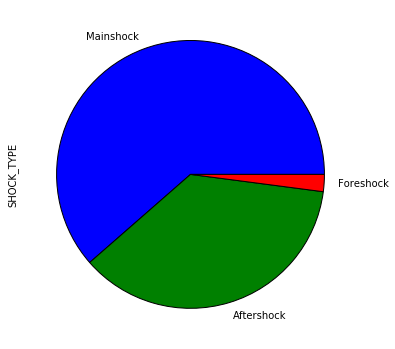

In [21]:
catalogue_df = pd.read_csv('../Catalogue/SACAT1900_2008v2.txt', sep='\t')
catalogue_df['SHOCK_TYPE'].value_counts().plot(kind='pie', figsize=(6, 6));
fig.savefig('ShockTypes.pdf', transparent=True, bbox_inches='tight', pad_inches=0.1)
plt.close(fig)  # uncomment to view in notebook

In [22]:
# augment catalogue with zone and layer info
catalogue_df['geometry'] = [Point(lon, lat) 
                            for lon, lat in zip(catalogue_df['LON'], 
                                                catalogue_df['LAT'])]
layer_catalogue_gdfs = []
for _, layer in layers_df.iterrows():
    layer_catalogue_gdf = gpd.GeoDataFrame(catalogue_df[
        (catalogue_df['DEPTH'] >= layer['zmin']) &
        (catalogue_df['DEPTH'] < layer['zmax'])], crs='WGS84')
    layer_areal_gdf = gpd.GeoDataFrame(areal_df[
        areal_df['layerid'] == layer['id']][['geometry', 'zoneid', 'layerid']], crs='WGS84')
    layer_catalogue_gdfs.append(gpd.sjoin(layer_catalogue_gdf, 
                                          layer_areal_gdf, how='left'))
catalogue_df = pd.concat(layer_catalogue_gdfs).drop('geometry')

In [23]:
pd.concat((catalogue_df.head(), catalogue_df.tail()))

,YEAR,MONTH,DAY,HH,MM,SS,LAT,LON,DEPTH,DEPTH_ERR,...,MAG,MAG_ERR,MAG_MW,MAG_MW_ERR,SOURCE,SHOCK_TYPE,geometry,index_right,zoneid,layerid
39,1906,10,4,6,52,-1.00,37.2000,67.3000,20.0,-1.0,...,5.70,-1.0,5.8,-1.00,AB2003a,Mainshock,POINT (67.3 37.2),NaN,NaN,NaN
46,1907,10,21,4,23,36.00,38.7000,68.1000,24.0,-1.0,...,7.30,-1.0,7.2,-1.00,UL2006a,Mainshock,POINT (68.09999999999999 38.7),NaN,NaN,NaN
48,1907,10,24,5,10,-1.00,38.0000,68.8000,18.0,-1.0,...,5.20,-1.0,5.5,-1.00,AB2003a,Mainshock,POINT (68.8 38),1.0,1m,1.0
48,1907,10,24,5,10,-1.00,38.0000,68.8000,18.0,-1.0,...,5.20,-1.0,5.5,-1.00,AB2003a,Mainshock,POINT (68.8 38),0.0,1,1.0
74,1911,1,1,14,59,0.00,36.5000,66.0000,20.0,-1.0,...,6.47,-1.0,6.4,-1.00,AB2003a,Mainshock,POINT (66 36.5),NaN,NaN,NaN
50295,2008,12,26,15,56,29.97,37.1880,72.0040,216.8,41.0,...,3.20,0.1,3.4,0.28,ISC,Mainshock,POINT (72.00399999999999 37.188),82.0,170,4.0
50297,2008,12,26,22,12,56.66,36.2475,70.3301,189.1,66.0,...,3.20,0.2,3.4,0.33,ISC,Mainshock,POINT (70.3301 36.2475),81.0,169,4.0
50317,2008,12,29,18,24,32.58,36.4481,71.0448,200.0,46.0,...,3.30,0.1,3.5,0.28,ISC,Aftershock,POINT (71.0448 36.4481),81.0,169,4.0
50319,2008,12,30,3,9,28.10,36.4556,70.9448,198.7,29.0,...,3.90,-1.0,4.6,0.19,ISC,Aftershock,POINT (70.9448 36.4556),81.0,169,4.0
50331,2008,12,31,20,48,35.71,36.2467,70.8264,197.0,44.0,...,3.30,0.1,3.5,0.28,ISC,Mainshock,POINT (70.82640000000001 36.2467),81.0,169,4.0


In [24]:
# for each minimum magnitude and layer work out the activity rates
catalogue_activity_df = pd.DataFrame()
for _, layer in pd.merge(completeness_df, layers_df).iterrows():
    layer_results = pd.Series()
    for mag in reversed(min_mags):
        above_thresh = catalogue_df['MAG_MW'] >= mag
        start = layer[str(mag) + ' start']
        end = layer[str(mag) + ' end']
        at_depth = ((catalogue_df['DEPTH'] >= layer['zmin']) &
                    (catalogue_df['DEPTH'] < layer['zmax']))
        in_years = ((catalogue_df['YEAR'] >= start) &
                    (catalogue_df['YEAR'] <= end))
        in_a_zone = catalogue_df['zoneid'] != -1
        is_mainshock = catalogue_df['SHOCK_TYPE'] == 'Mainshock'
        subcat_df = catalogue_df[
            above_thresh & at_depth & in_years & in_a_zone & is_mainshock]
        layer_results = layer_results.append(pd.Series({
            'catalogue ' + str(mag):
                round(float(len(subcat_df))/(end - start + 1), 1),
            }, name=layer['id']))
    catalogue_activity_df = catalogue_activity_df.append(layer_results, ignore_index=True)
catalogue_activity_df = catalogue_activity_df.append(pd.Series(
    catalogue_activity_df.sum(axis=0), name='Total'))

In [25]:
activity_df = layer_activity_df.join(catalogue_activity_df)
model_type = [item.split()[0] for item in activity_df.columns]
model_type = ['catalogue' if item == 'cat' else item for item in model_type]
min_mag = [float(item.split()[1]) for item in activity_df.columns]
activity_df.columns = [min_mag, model_type]
multi_cols = pd.MultiIndex.from_tuples([
   (4.5, 'areal'), (4.5, 'smoothed'), (4.5, 'catalogue'),
   (5.5, 'areal'), (5.5, 'smoothed'), (5.5, 'catalogue'),
   ], names=['source', 'minimum magnitude'])
# activity_df[('layerid', 'minimum magnitude')] = activity_df.index
# activity_df.index = range(len(activity_df))

activity_df = activity_df[multi_cols]
display(activity_df)
summary_tex = os.path.join(
    smoothed_model_path,
    'activity_rates_by_layer_areal_vs_smoothed_vs_catalogue.tex')
activity_df.to_latex(summary_tex, index_names=True,)

4.5                      5.5                   
       areal smoothed catalogue areal smoothed catalogue
0       98.8    129.7     105.4  10.9      4.0       6.0
1      101.3    165.2     142.5  13.5      3.4       7.2
2       35.7     88.5      44.3   2.9      1.7       1.8
3       11.5     42.6      10.9   1.6      1.2       1.3
Total  247.3    426.0     303.1  28.9     10.3      16.3

In [26]:
min_mag = 5.5
layer_id = 1
model_layer = ((smoothed_df['mmin model'] == min_mag) &
               (smoothed_df['layerid'] == layer_id))
subset_df = smoothed_df[model_layer].copy()

lon_list = sorted(list(set(subset_df['longitude'])))
lat_list = sorted(list(set(subset_df['latitude'])))

lon_min, lon_max = [min(lon_list), max(lon_list)]
lat_min, lat_max = [min(lat_list), max(lat_list)]
lon_res = np.diff(lon_list).min().round(2)
lat_res = np.diff(lat_list).min().round(2)

lon_list = np.arange(lon_min, lon_max + lon_res, lon_res).round(2)
lat_list = np.arange(lat_min, lat_max + lat_res, lat_res).round(2)
lat_grid, lon_grid = np.meshgrid(lat_list, lon_list)

# assign known values
num_columns = ['a', 'b', 'nu', 'lambda']
txt_columns = ['tectonic subregion']
data = {}
for column in num_columns:
    data[column] = np.full_like(lon_grid, np.nan)
for column in txt_columns:
    data[column] = np.full_like(lon_grid, '', dtype='object')

for _, point_series in subset_df.iterrows():
    i = int(round((point_series['longitude'] - lon_min)/lon_res))
    j = int(round((point_series['latitude'] - lat_min)/lat_res))
    for column in num_columns:
        data[column][i, j] = point_series[column]
    for column in txt_columns:
        data[column][i, j] = point_series[column]

/home/nick/anaconda3/envs/oq/lib/python3.5/site-packages/numpy/lib/function_base.py:583: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/home/nick/anaconda3/envs/oq/lib/python3.5/site-packages/numpy/lib/function_base.py:584: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


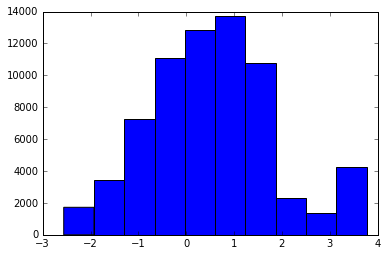

In [27]:
param = 'a'
if param in ['nu', 'lambda']:
    log_scale = True
else:
    log_scale = False
limits = (np.nanmin(data[param]), np.nanmax(data[param]))
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.hist(data[param].ravel(), range=limits, log=log_scale)
fig.savefig("SmoothedEquivalentMap_%s_mmin%g_layer%d.png" %
            (param, min_mag, layer_id), dpi=150,
            transparent=True, bbox_inches='tight', pad_inches=0.1)
plt.close(fig)  # uncomment to view in notebook

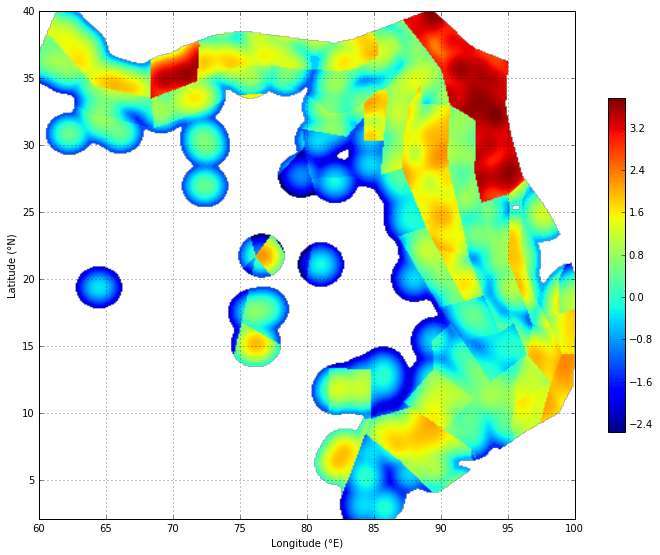

In [28]:
fig, ax = plt.subplots()
if log_scale:
    ax.imshow(data[param], cmap='jet', origin='lower', aspect='equal',
               extent=(lon_min, lon_max, lat_min, lat_max),
               norm=LogNorm(vmin=limits[0], vmax=limits[1]))
else:
    ax.imshow(data[param], cmap='jet', origin='lower', aspect='equal',
               extent=(lon_min, lon_max, lat_min, lat_max))

fig.colorbar(shrink=0.5)
ax.set_xlabel(u'Longitude (°E)')
ax.set_ylabel(u'Latitude (°N)')
ax.grid()
fig.savefig(os.path.join(smoothed_model_path,
                         'SmoothedEquivalentMap_%s_mmin%g_layer%d.pdf' %
                         (param, min_mag, layer_id)),
            dpi=300, transparent=True, bbox_inches='tight', pad_inches=0.1)
plt.close(fig)  # uncomment to view in notebook

In [29]:
def is_close_multiple(a, b):
    dividend = a/b
    return np.isclose(dividend - round(dividend), 0)

In [30]:
# drop columns and optionally thin smoothed DataFrame before writing to CSV
res_deg = 1.0
thinned_df = smoothed_df.copy()
thinned_df.drop(['aspect ratio', 'rake', 'dip', 'strike', 'msr', 
                 'geometry', 'stdb', 'stdmmax'], axis=1, inplace=True)
thinned_df = thinned_df[
    is_close_multiple(thinned_df['latitude'], res_deg) &
    is_close_multiple(thinned_df['longitude'], res_deg)]

resolution_adjustment = float(len(smoothed_df))/float(len(thinned_df))
print('Adjusting activity for a change in resolution of %g' %
      resolution_adjustment)
thinned_df['nu'] = thinned_df['nu']*resolution_adjustment
thinned_df['lambda'] = thinned_df['lambda']*resolution_adjustment
thinned_df['a'] = thinned_df['a'] + np.log10(resolution_adjustment)

# write each layer to CSV with added binwise rates
for min_mag in reversed(min_mags):
    for layer_id in reversed(layer_ids):
        temp_df = smt.add_name_id(thinned_df)
        this_model_layer = ((temp_df['mmin model'] == min_mag) &
                            (temp_df['layerid'] == layer_id))
        temp_df.drop(['zmax', 'zmin', 'mmin model', 'layerid'],
                     axis=1, inplace=True)
        model_name = ('%s %s mmin %g layer %d' %
                      (os.path.split(smoothed_model_path)[1],
                       smoothed_source_data_file, min_mag, layer_id))

        # smt.source_df_to_kml(temp_df.loc[this_model_layer, :], model_name)

        csv_file = model_name.replace(' ', '_') + '.csv'
        temp_df.loc[this_model_layer, :].to_csv(csv_file, index=False, float_format='%.12g')

Adjusting activity for a change in resolution of 100.619


In [31]:
# write point source models without twinning to TSV file
for min_mag in min_mags:
    smoothed_output_df = smoothed_df[smoothed_df['mmin model'] == min_mag]
    smoothed_output_df = smt.sort_and_reindex(
        smt.add_name_id(smoothed_output_df))
    smoothed_output_df.drop(['mmin model'], axis=1, inplace=True)
    smoothed_output_df['lambda'] = tb.limit_precision(
        smoothed_output_df['lambda'].values)
    smoothed_output_df['a'] = tb.limit_precision(
        smoothed_output_df['a'].values)
    smoothed_tsv = '%s_%s_mmin_%g.tsv' % (
        os.path.split(smoothed_model_path)[1],
        smoothed_source_data_file, min_mag)
    smoothed_output_df.to_csv(smoothed_tsv, sep='\t', index=False, float_format='%.12g')

In [32]:
# write point source models with megathrust sources twinned to NRML
for min_mag in min_mags:
    this_model = smoothed_df['mmin model'] == min_mag
    smoothed_source_list = smt.source_df_to_list(
        smt.add_name_id(
            smt.twin_source_by_magnitude(smoothed_df.loc[this_model, :])))
    smoothed_source_model = src.source_model.mtkSourceModel(
        identifier='1',
        name=os.path.split(model_path)[1] + 'smoothed m_min=%g' % min_mag,
        sources=smoothed_source_list)
    file_name = '%s_%s_mmin%g.xml' % (os.path.split(smoothed_model_path)[1],
                                      smoothed_source_data_file, min_mag)
    smoothed_source_model.serialise_to_nrml(file_name)